<a href="https://colab.research.google.com/github/GeorgeQiao/prostate_cancer/blob/master/Copy_of_feature_processing_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Machine Learning techniques on the features Selection - They ARE CALLABLE FUNCTIONS ONLY.
'''

# import statements
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
from pprint import pprint
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


# set import variables
pd.set_option("expand_frame_repr", False)
pd.set_option("max_columns", 9)
np.random.seed(0)
warnings.filterwarnings("ignore")

def do_t_risk(t_data, filenames, mode):
	if mode == 'partial':
		print(t_data[0].head())
	# FEATURE SELECTION
	# Select K-Best Features, Scale Values and Select from RF Model
	kbest = SelectKBest(score_func=chi2, k=10000)
	scaler = StandardScaler()
	fs_data = []
	for i, d in enumerate(t_data):
		print("\nFILENAME: {}".format(filenames[i]))
		t_rows = list(d.index)
		t_columns = d.columns[2:]
		# K-best
        print(d)
		selector = kbest.fit(d.iloc[2:, :], d.iloc[2, :])
		t_columns = t_columns[selector.get_support()]
		fs_data.append(pd.DataFrame(selector.transform(t_data[i].iloc[2:, :]), columns = t_columns, index=t_rows))
		if mode == 'show':
			print("Selecting k best features -\n", fs_data[i].head())
		# Scale 
		t_columns = fs_data[i].columns
		fs_data[i] = pd.DataFrame(scaler.fit_transform(fs_data[i]), columns=t_columns, index=t_rows)
		if mode == 'show':
			print("Scaling data -\n", fs_data[i].head())
		# Select from RF
		classifier = RandomForestClassifier(n_estimators=1)
		classifier = classifier.fit(fs_data[i], d['group'])
		selector = SelectFromModel(classifier, prefit=True)
		t_columns = t_columns[selector.get_support()]
		fs_data[i] = pd.DataFrame(selector.transform(fs_data[i]), columns=t_columns, index=t_rows)
		fs_data[i]['group'] = d['group']
		if mode == 'show':
			print("Selecting data from RF model -\n", fs_data[i].head())
		print("Shape after feature selection: {}".format(fs_data[i].shape), end="\n\n")
	# RESAMPLING the data - SMOTEENN
	balanced_data = [[] for _ in range(2)]
	for i, d in enumerate(fs_data):
		sme = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=3))
		x, y = sme.fit_resample(fs_data[i], t_data[i]['group'])
		# x are the features and y are the targets
		balanced_data[i].append(x)
		balanced_data[i].append(y)
		if mode == 'show':
			print("FILENAME: {}".format(filenames[i]), Counter(balanced_data[i][1]))
	# DIMENSIONALITY REDUCTION
	# Kernel PCA and LDA (can be toggled on or off)
	pca = True
	pca_dim = 31
	lda = True
	lda_dim = 5
	if pca or lda:
		dr_data = []
		for i in range(len(filenames)):
			print("\nFILENAME: {}".format(filenames[i]))
			if pca:
				decomposer = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=0.05, degree=7)
				dr_data.append(decomposer.fit_transform(balanced_data[i][0]))
				print("Shape and type after PCA: ", dr_data[i].shape, type(dr_data[i]))
			if lda:
				decomposer = LinearDiscriminantAnalysis(n_components=lda_dim, solver='eigen')
				dr_data[i] = decomposer.fit_transform(dr_data[i], balanced_data[i][1])
				print("Shape and type after LDA: ", dr_data[i].shape, type(dr_data[i]))
	else:
		dr_data.append(balanced_data[0][0])
		dr_data.append(balanced_data[1][0])
	# CLASSIFICATION
	splits = 7
	seed = 7
	kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
	results = {'SVM': [],
				'RF': [],
				'KNN': [],
				'NB': []
				}
	for i, d in enumerate(dr_data):
		# SVM
		res = []
		classifier = SVC(gamma='auto')
		results['SVM'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['SVM'][i] = results['SVM'][i].mean()
		# RF
		classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=7, criterion='gini')
		results['RF'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['RF'][i] = results['RF'][i].mean()
		# KNN
		knn = KNeighborsClassifier(n_neighbors=5)
		results['KNN'].append(cross_val_score(knn, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['KNN'][i] = results['KNN'][i].mean()
		# NB
		nb = GaussianNB()
		results['NB'].append(cross_val_score(nb, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['NB'][i] = results['NB'][i].mean()
	print("\nFinal Results for datasets: {0}, {1} -".format(filenames[0], filenames[1]))
	pprint(results)
	# PLOTTING
	# PCA
	pca = PCA(n_components = 3)
	x_pca = pca.fit_transform(balanced_data[0][0])
	fig = plt.figure(figsize=(10, 6))
	plt.suptitle("3-D plot for resampled data using dimesnionality reduction (group)\n\n")
	ax = fig.add_subplot(121, projection='3d')
	ax.set_title("PCA\n\n")
	ax.view_init(elev=15,azim=66)
	for i in range(len(balanced_data[0][1])):
		if balanced_data[0][1][i] == 0:
			t2a = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='y', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 1:
			t2b = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='g', label=balanced_data[0][1][i])
	plt.legend((t2a, t2b),
		('0', '1'),
		scatterpoints=1,
		loc='upper right',
		ncol=1,
		fontsize=10)
	# PCA + LDA
	pca = PCA(n_components = 10)
	x_pca = pca.fit_transform(balanced_data[0][0])
	lda = LinearDiscriminantAnalysis(n_components = 3)
	x_lda = lda.fit_transform(x_pca, balanced_data[0][1])
	ax = fig.add_subplot(122, projection='3d')
	plt.title("PCA & LDA\n\n")
	ax.view_init(elev=-79,azim=-7)
	for i in range(len(balanced_data[0][1])):
		if balanced_data[0][1][i] == 0:
			t2a = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='y', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 1:
			t2b = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='g', label=balanced_data[0][1][i])
	plt.legend((t2a, t2b),
				('0', '1'),
				scatterpoints=1,
				loc='upper right',
				ncol=1,
				fontsize=10)
	#plt.show()
	return results

def do_t_stage(t_data, filenames, mode):
	if mode == 'partial':
		print(t_data[0].head())
	# FEATURE SELECTION
	# Select K-Best Features, Scale Values and Select from RF Model
	kbest = SelectKBest(score_func=chi2, k=10000)
	scaler = StandardScaler()
	fs_data = []
	for i, d in enumerate(t_data):
		print("\nFILENAME: {}".format(filenames[i]))
		t_rows = list(d.index)
		t_columns = d.columns[:-3]
		# K-best
		selector = kbest.fit(d.iloc[:, :-3], d.iloc[:, -3])
		t_columns = t_columns[selector.get_support()]
		fs_data.append(pd.DataFrame(selector.transform(t_data[i].iloc[:, :-3]), columns = t_columns, index=t_rows))
		if mode == 'show':
			print("Selecting k best features -\n", fs_data[i].head())
		# Scale 
		t_columns = fs_data[i].columns
		fs_data[i] = pd.DataFrame(scaler.fit_transform(fs_data[i]), columns=t_columns, index=t_rows)
		if mode == 'show':
			print("Scaling data -\n", fs_data[i].head())
		# Select from RF
		classifier = RandomForestClassifier(n_estimators=1)
		classifier = classifier.fit(fs_data[i], d['TStage'])
		selector = SelectFromModel(classifier, prefit=True)
		t_columns = t_columns[selector.get_support()]
		fs_data[i] = pd.DataFrame(selector.transform(fs_data[i]), columns=t_columns, index=t_rows)
		fs_data[i]['TStage'] = d['TStage']
		if mode == 'show':
			print("Selecting data from RF model -\n", fs_data[i].head())
		print("Shape after feature selection: {}".format(fs_data[i].shape), end="\n\n")
	# RESAMPLING the data - SMOTEENN
	balanced_data = [[] for _ in range(2)]
	for i, d in enumerate(fs_data):
		sme = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=3))
		x, y = sme.fit_resample(fs_data[i], t_data[i]['TStage'])
		# x are the features and y are the targets
		balanced_data[i].append(x)
		balanced_data[i].append(y)
		if mode == 'show':
			print("FILENAME: {}".format(filenames[i]), Counter(balanced_data[i][1]))
	# DIMENSIONALITY REDUCTION
	# Kernel PCA and LDA (can be toggled on or off)
	pca = True
	pca_dim = 31
	lda = True
	lda_dim = 5
	if pca or lda:
		dr_data = []
		for i in range(len(filenames)):
			print("\nFILENAME: {}".format(filenames[i]))
			if pca:
				decomposer = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=0.05, degree=7)
				dr_data.append(decomposer.fit_transform(balanced_data[i][0]))
				print("Shape and type after PCA: ", dr_data[i].shape, type(dr_data[i]))
			if lda:
				decomposer = LinearDiscriminantAnalysis(n_components=lda_dim, solver='eigen')
				dr_data[i] = decomposer.fit_transform(dr_data[i], balanced_data[i][1])
				print("Shape and type after LDA: ", dr_data[i].shape, type(dr_data[i]))
	else:
		dr_data.append(balanced_data[0][0])
		dr_data.append(balanced_data[1][0])
	# CLASSIFICATION
	splits = 7
	seed = 7
	kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
	results = {'SVM': [],
				'RF': [],
				'KNN': [],
				'NB': []
				}
	for i, d in enumerate(dr_data):
		# SVM
		res = []
		classifier = SVC(gamma='auto')
		results['SVM'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['SVM'][i] = results['SVM'][i].mean()
		# RF
		classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=7, criterion='gini')
		results['RF'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['RF'][i] = results['RF'][i].mean()
		# KNN
		knn = KNeighborsClassifier(n_neighbors=5)
		results['KNN'].append(cross_val_score(knn, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['KNN'][i] = results['KNN'][i].mean()
		# NB
		nb = GaussianNB()
		results['NB'].append(cross_val_score(nb, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['NB'][i] = results['NB'][i].mean()
	print("\nFinal Results for datasets: {0}, {1} -".format(filenames[0], filenames[1]))
	pprint(results)
	# PLOTTING
	# PCA
	pca = PCA(n_components = 3)
	x_pca = pca.fit_transform(balanced_data[0][0])
	fig = plt.figure(figsize=(10, 6))
	plt.suptitle("3-D plot for resampled data using dimesnionality reduction (T-Stage)\n\n")
	ax = fig.add_subplot(121, projection='3d')
	ax.set_title("PCA\n\n")
	ax.view_init(elev=15,azim=66)
	for i in range(len(balanced_data[0][1])):
		if balanced_data[0][1][i] == 0:
			t2a = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='y', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 1:
			t2b = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='g', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 2:
			t2c = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='b', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 3:
			t3a = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='r', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 4:
			t3b = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='m', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 5:
			t4 = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='c', label=balanced_data[0][1][i])
	plt.legend((t2a, t2b, t2c, t3a, t3b, t4),
		('T2a', 'T2b', 'T2c','T3a','T3b', 'T4'),
		scatterpoints=1,
		loc='upper right',
		ncol=1,
		fontsize=10)
	# PCA + LDA
	pca = PCA(n_components = 10)
	x_pca = pca.fit_transform(balanced_data[0][0])
	lda = LinearDiscriminantAnalysis(n_components = 3)
	x_lda = lda.fit_transform(x_pca, balanced_data[0][1])
	ax = fig.add_subplot(122, projection='3d')
	plt.title("PCA & LDA\n\n")
	ax.view_init(elev=-79,azim=-7)
	for i in range(len(balanced_data[0][1])):
		if balanced_data[0][1][i] == 0:
			t2a = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='y', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 1:
			t2b = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='g', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 2:
			t2c = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='b', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 3:
			t3a = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='r', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 4:
			t3b = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='m', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 5:
			t4 = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='c', label=balanced_data[0][1][i])
	plt.legend((t2a, t2b, t2c, t3a, t3b, t4),
				('T2a', 'T2b', 'T2c','T3a','T3b', 'T4'),
				scatterpoints=1,
				loc='upper right',
				ncol=1,
				fontsize=10)
	#plt.show()
	return results


def do_gleason(t_data, filenames, mode):
	# FEATURE SELECTION
	# Select K-Best Features, Scale, VarianceThreshold and Select From RF Model
	kbest = SelectKBest(score_func=chi2, k=15000)
	scaler = StandardScaler()
	thresholding = VarianceThreshold()
	fs_data = []
	for i, d in enumerate(t_data):
		print("\nFILENAME: {}".format(filenames[i]))
		t_rows = list(d.index)
		t_columns = d.columns[:-3]
		# K-best
		selector = kbest.fit(d.iloc[:, :-3], d.iloc[:, -2])
		t_columns = t_columns[selector.get_support()]
		fs_data.append(pd.DataFrame(selector.transform(t_data[i].iloc[:, :-3]), columns = t_columns, index=t_rows))
		if mode == 'show':
			print("Selecting k best features -\n", fs_data[i].head())
		# Scale 
		t_columns = fs_data[i].columns
		fs_data[i] = pd.DataFrame(scaler.fit_transform(fs_data[i]), columns=t_columns, index=t_rows)
		if mode == 'show':
			print("Scaling data -\n", fs_data[i].head())
		# Variance Threshold
		fs_data[i] = pd.DataFrame(thresholding.fit_transform(fs_data[i]), columns=t_columns, index=t_rows)
		if mode == 'show':
			print("After variance thresholding -\n", fs_data[i].head())
		# Select from RF
		classifier = RandomForestClassifier(n_estimators=1)
		classifier = classifier.fit(fs_data[i], d['Gleason'])
		selector = SelectFromModel(classifier, prefit=True)
		t_columns = t_columns[selector.get_support()]
		fs_data[i] = pd.DataFrame(selector.transform(fs_data[i]), columns=t_columns, index=t_rows)
		fs_data[i]['Gleason'] = d['Gleason']
		if mode in ('show'):
			print("Selecting data from RF model -\n", fs_data[i].head())
		print("Shape after feature selection: {}".format(fs_data[i].shape), end="\n\n")
	# RESAMPLING data - SMOTEENN
	balanced_data = [[] for _ in range(2)]
	for i, d in enumerate(fs_data):
		sme = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=1))
		x, y = sme.fit_resample(fs_data[i], t_data[i]['Gleason'])
		# x are the features and y are the targets
		balanced_data[i].append(x)
		balanced_data[i].append(y)
		if mode == 'show':
			print("FILENAME: {}".format(filenames[i]), Counter(balanced_data[i][1]))
	# DIMENSIONALITY REDUCTION
	# Kernel PCA and LDA (can be toggled on or off)
	pca = False
	pca_dim = 31
	lda = True
	lda_dim = 3
	if pca or lda:
		dr_data = []
		for i in range(len(filenames)):
			print("\nFILENAME: {}".format(filenames[i]))
			if pca:
				decomposer = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=0.05, degree=7)
				dr_data.append(decomposer.fit_transform(balanced_data[i][0]))
				print("Shape and type after PCA: ", dr_data[i].shape, type(dr_data[i]))
			else:
				dr_data.append(balanced_data[i][0])
			if lda:
				decomposer = LinearDiscriminantAnalysis(n_components=lda_dim)
				dr_data[i] = decomposer.fit_transform(dr_data[i], balanced_data[i][1])
				print("Shape and type after LDA: ", dr_data[i].shape, type(dr_data[i]))
	else:
		dr_data.append(balanced_data[0][0])
		dr_data.append(balanced_data[1][0])
	# CLASSIFICATION
	splits = 10
	seed = 7
	kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
	results = {'SVM': [],
				'RF': [],
				'KNN': [],
				'NB': []
				}
	for i, d in enumerate(dr_data):
		# SVM
		res = []
		classifier = SVC(gamma='auto')
		results['SVM'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['SVM'][i] = results['SVM'][i].mean()
		# RF
		# rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=10,max_features='auto')
		classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=7, max_features='auto', criterion='gini') #, n_jobs=-1
		results['RF'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['RF'][i] = results['RF'][i].mean()
		# KNN
		k_scores = []
		for n in range(1, 16):
			knn = KNeighborsClassifier(n_neighbors=3)
			scores = (cross_val_score(knn, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
			k_scores.append(scores.mean())
		results['KNN'].append(max(k_scores))
		# NB
		nb = GaussianNB()
		results['NB'].append(cross_val_score(nb, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['NB'][i] = results['NB'][i].mean()
	print("\nFinal Results for datasets: {0}, {1} -".format(filenames[0], filenames[1]))
	pprint(results)
	# PLOTTING
	# PCA
	pca = PCA(n_components = 3)
	x_pca = pca.fit_transform(balanced_data[0][0])
	fig = plt.figure(figsize=(13, 7))
	plt.suptitle("3-D plot for resampled data using dimesnionality reduction (Gleason Score)\n\n")
	ax = fig.add_subplot(121, projection='3d')
	ax.set_title("PCA\n\n")
	ax.view_init(elev=177,azim=-96)
	for i in range(len(balanced_data[0][1])):
		if balanced_data[0][1][i] == 6:
			six = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='y', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 7:
			seven = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='g', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 8:
			eight = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='b', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 9:
			nine = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='r', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 10:
			ten = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='m', label=balanced_data[0][1][i])
	plt.legend((six, seven, eight, nine, ten),
		('6', '7', '8','9','10'),
		scatterpoints=1,
		loc='upper right',
		ncol=1,
		fontsize=10)
	# PCA + LDA
	pca = PCA(n_components = 10)
	x_pca = pca.fit_transform(balanced_data[0][0])
	lda = LinearDiscriminantAnalysis(n_components = 3)
	x_lda = lda.fit_transform(x_pca, balanced_data[0][1])
	ax = fig.add_subplot(122, projection='3d')
	plt.title("PCA & LDA\n\n")
	ax.view_init(elev=10,azim=-112)
	for i in range(len(balanced_data[0][1])):
		if balanced_data[0][1][i] == 6:
			six = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='y', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 7:
			seven = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='g', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 8:
			eight = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='b', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 9:
			nine = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='r', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 10:
			ten = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='m', label=balanced_data[0][1][i])
	plt.legend((six, seven, eight, nine, ten),
				('6', '7', '8','9','10'),
				scatterpoints=1,
				loc='upper right',
				ncol=1,
				fontsize=10)
	#plt.show()
	return results


def do_t_recur(t_data, filenames, mode):
	# FEATURE SELECTION
	# Scale, Use VarianceThreshold and Pearson Correlation, and Select From RF Model
	scaler = MinMaxScaler()
	thresholding = VarianceThreshold()
	fs_data = []
	for i, d in enumerate(t_data):
		print("\nFILENAME: {}".format(filenames[i]))
		t_rows = list(d.index)
		t_columns = d.columns[:-3]
		# Replace NaN values with the column mean
		t_data[i]['Recurrence'].fillna((t_data[i]['Recurrence'].mean()), inplace=True)
		# Scale
		fs_data.append(pd.DataFrame(scaler.fit_transform(t_data[i].iloc[:, :-3]), columns=t_columns, index=t_rows))
		if mode == 'show':
			print("Scaling data -\n", fs_data[i].head())
		# Variance Threshold
		selector = thresholding.fit(fs_data[i])
		t_columns = t_columns[thresholding.get_support()]
		fs_data[i] = pd.DataFrame(thresholding.transform(fs_data[i]), columns=t_columns, index=t_rows)
		if mode == 'show':
			print("After variance thresholding -\n", fs_data[i].head())
		# Select From RF
		classifier = RandomForestClassifier(n_estimators=1)
		classifier = classifier.fit(fs_data[i], d['Recurrence'])
		selector = SelectFromModel(classifier, prefit=True)
		t_columns = t_columns[selector.get_support()]
		fs_data[i] = pd.DataFrame(selector.transform(fs_data[i]), columns=t_columns, index=t_rows)
		fs_data[i]['Recurrence'] = d['Recurrence']
		if mode in ('show'):
			print("Selecting data from RF model -\n", fs_data[i].head())
		print("Shape after feature selection: {}".format(fs_data[i].shape), end="\n\n")
	# RESAMPLING data - SMOTEENN
	balanced_data = [[] for _ in range(2)]
	for i, d in enumerate(fs_data):
		sme = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=2))
		x, y = sme.fit_resample(fs_data[i], t_data[i]['Recurrence'])
		# x are the features and y are the targets
		balanced_data[i].append(x)
		balanced_data[i].append(y)
		print("Upsampling the data... in {}".format(filenames[i]))
		if mode == 'show':
			print("FILENAME: {}".format(filenames[i]), Counter(balanced_data[i][1]))
	# DIMENSIONALITY REDUCTION
	# Kernel PCA (can be toggled on or off)
	pca = True
	pca_dim = 20
	if pca:
		dr_data = []
		for i in range(len(filenames)):
			print("\nFILENAME: {}".format(filenames[i]))
			decomposer = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=0.5, degree=7)
			dr_data.append(decomposer.fit_transform(balanced_data[i][0]))
			print("Shape and type after PCA: ", dr_data[i].shape, type(dr_data[i]))
	else:
		dr_data.append(balanced_data[0][0])
		dr_data.append(balanced_data[1][0])
	# CLASSIFICATION
	splits = 10
	seed = 7
	kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
	results = {'SVM': [],
				'RF': [],
				'KNN': [],
				'NB': []
				}
	for i, d in enumerate(dr_data):
		# SVM
		res = []
		classifier = SVC(gamma='auto')
		results['SVM'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['SVM'][i] = results['SVM'][i].mean()
		# RF
		# rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=10,max_features='auto')
		classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=7, max_features='auto', criterion='gini', n_jobs=-1)
		results['RF'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['RF'][i] = results['RF'][i].mean()
		# KNN
		k_scores = []
		for n in range(1, 16):
			knn = KNeighborsClassifier(n_neighbors=3)
			scores = (cross_val_score(knn, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
			k_scores.append(scores.mean())
		results['KNN'].append(max(k_scores))
		# NB
		nb = GaussianNB()
		results['NB'].append(cross_val_score(nb, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
		results['NB'][i] = results['NB'][i].mean()
	print("\nFinal Results for datasets: {0}, {1} -".format(filenames[0], filenames[1]))
	pprint(results)
	# PLOTTING
	# PCA
	pca = PCA(n_components = 3)
	x_pca = pca.fit_transform(balanced_data[0][0])
	fig = plt.figure(figsize=(13, 7))
	plt.suptitle("3-D plot for resampled data using dimesnionality reduction (Biomedical Recurrence)\n\n")
	ax = fig.add_subplot(111, projection='3d')
	ax.set_title("PCA\n\n")
	ax.view_init(elev=177,azim=-96)
	for i in range(len(balanced_data[0][1])):
		if balanced_data[0][1][i] == 0:
			false = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='y', label=balanced_data[0][1][i])
		elif balanced_data[0][1][i] == 1:
			true = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='g', label=balanced_data[0][1][i])
	plt.legend((false, true),
		("Didn't recur", "Recurred"),
		scatterpoints=1,
		loc='upper right',
		ncol=1,
		fontsize=10)
	#plt.show()
	return results


def main():
	print('This file contains only callable functions. Run "final_compiled.py" instead.')


if __name__ == "__main__":
	main()

TabError: ignored

[0    index           Samples  group  ENSG00000004468  ...  ENSG00000280725  ENSG00000280800  ENSG00000281131  ENSG00000281566
0        1  TCGA-VN-A88K-01A      1         0.054718  ...         0.000000              0.0         3.244470         0.000000
1        2  TCGA-ZG-A9ND-01A      1         1.226355  ...         0.121655              0.0         0.022344         0.000000
2        3  TCGA-EJ-A65F-01A      1         0.143490  ...         0.019424              0.0         8.918967         0.000000
3        4  TCGA-ZG-A9L1-01A      1         4.120039  ...         0.030949              0.0         2.091828         0.000000
4        5  TCGA-YL-A8HL-01A      1         9.151929  ...         0.000000              0.0       106.665524         0.000000
..     ...               ...    ...              ...  ...              ...              ...              ...              ...
407    408  TCGA-XK-AAK1-01A      0        13.889672  ...         0.000000              0.0         0.055930         

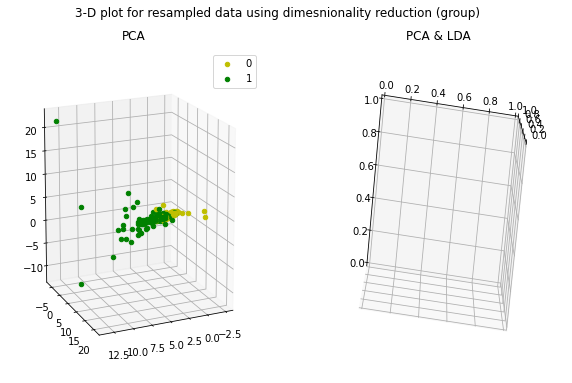

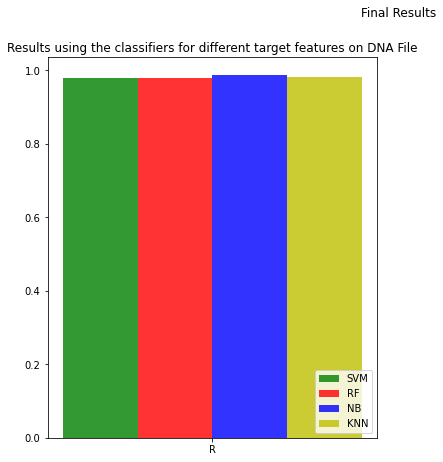

In [ ]:
'''
Predicting Features from the Pathology Report for Prostate Cancer.

Gleason Score
T-Stage
Biomedical Recurrence
'''

# import statements
import os
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.ensemble import IsolationForest
#from feature_processing import do_t_stage, do_gleason, do_t_recur


# set module variables 
pd.set_option("expand_frame_repr", False)
pd.set_option("max_columns", 9)
np.random.seed(0)
warnings.filterwarnings("ignore")



modes = ['show', 'partial', 'hide']
mode = modes[1]

# filepaths to data downloaded from cBioPortal
filepath = "prad_tcga"			# base directory
#filenames = ["data_methylation_hm450.txt", "data_RNA_Seq_v2_expression_median.txt"]
filenames=["TCGA-FPKM-DEG.xlsx"]
clinicalfile = "prad_tcga_clinical_data.tsv"

# import the gene data (contains gene data to use as x-features while predicting)
data = []
for i, filename in enumerate(filenames):
    TCGA_PRAD = pd.read_excel("TCGA-FPKM-DEG.xlsx", header =None)
    TCGA_PRAD = TCGA_PRAD.T
    a = TCGA_PRAD
    a = a.T
    header_1 = a.iloc[0]
    a = a[1:]
    a.columns = header_1
    a = a.reset_index()
    TCGA_processed = a

    TCGA_processed = TCGA_processed.rename(columns={np.nan: 'samples'})
        # data is tab separated
    data.append(TCGA_processed)
    #data.append(pd.read_csv(os.path.join(filepath, filenames[i]), sep="\t"))
    # drop data columns that will not be used and change the index of the DataFrame
    #data[i].drop('Entrez_Gene_Id', axis=1, inplace=True)
    #data[i].set_index('Hugo_Symbol', inplace=True)
    if mode == 'show':
        print('FILENAME: {0} -\n'.format(filenames[i]), data[i].head())
# import the clinical data (contains target features to predict)
#clinical_data = pd.read_csv(os.path.join(filepath, clinicalfile), sep="\t")
#clinical_data.set_index('Sample ID', inplace=True)
#if mode == 'show':
#	print('FILENAME: clinical_data -\n', clinical_data.head())

# Transpose the gene data and add the target features to it
t_data = []
for i, d in enumerate(data):
    t_data.append(d.fillna(d.mean()))
    #missing = clinical_data.index.difference(d.transpose().index).tolist()

print(t_data)
# change TStage and Recurrence to integer values
for i, d in enumerate(t_data):
    t_data[i] = t_data[i][pd.notnull(t_data[i]['group'])]
    enc = LabelEncoder()
    # fit encoder to TStage 
    enc.fit(t_data[i]['group'].tolist())
    t_data[i]['group'] = enc.transform(t_data[i]['group'].tolist())
    tstage_mapping = dict(zip(enc.transform(enc.classes_), enc.classes_))
    # fit encoder to Recurrence

print("\t\tRisk-Level")

kbest = SelectKBest(score_func=chi2, k=350)
scaler = StandardScaler()
fs_data = []
for i, d in enumerate(t_data):
    print("\nFILENAME: {}".format(filenames[i]))
    t_rows = list(d.index)
    t_columns = d.columns[3:]
    print(t_columns)
    # K-best
    print(d)

    selector = kbest.fit(d.iloc[:, 3:], d.iloc[:, 2])
    t_columns = t_columns[selector.get_support()]
    fs_data.append(pd.DataFrame(selector.transform(t_data[i].iloc[:, 3:]), columns = t_columns, index=t_rows))
    if mode == 'show':
        print("Selecting k best features -\n", fs_data[i].head())
    # Scale 
    t_columns = fs_data[i].columns
    fs_data[i] = pd.DataFrame(scaler.fit_transform(fs_data[i]), columns=t_columns, index=t_rows)
    if mode == 'show':
        print("Scaling data -\n", fs_data[i].head())
    # Select from RF
    classifier = RandomForestClassifier(n_estimators=1)
    classifier = classifier.fit(fs_data[i], d['group'])
    selector = SelectFromModel(classifier, prefit=True)
    t_columns = t_columns[selector.get_support()]
    fs_data[i] = pd.DataFrame(selector.transform(fs_data[i]), columns=t_columns, index=t_rows)
    fs_data[i]['group'] = d['group']
    if mode == 'show':
        print("Selecting data from RF model -\n", fs_data[i].head())
    print("Shape after feature selection: {}".format(fs_data[i].shape), end="\n\n")
# RESAMPLING the data - SMOTEENN
balanced_data = [[] for _ in range(2)]
for i, d in enumerate(fs_data):
    sme = SMOTEENN(random_state=42, smote=SMOTE(random_state=42, k_neighbors=3))
    x, y = sme.fit_resample(fs_data[i], t_data[i]['group'])
    # x are the features and y are the targets
    balanced_data[i].append(x)
    balanced_data[i].append(y)
    if mode == 'show':
        print("FILENAME: {}".format(filenames[i]), Counter(balanced_data[i][1]))
# DIMENSIONALITY REDUCTION
# Kernel PCA and LDA (can be toggled on or off)
pca = True
pca_dim = 31
lda = True
lda_dim = 5
if pca or lda:
    dr_data = []
    for i in range(len(filenames)):
        print("\nFILENAME: {}".format(filenames[i]))
        if pca:
            decomposer = KernelPCA(n_components=pca_dim, kernel='rbf', gamma=0.05, degree=7)
            dr_data.append(decomposer.fit_transform(balanced_data[i][0]))
            print("Shape and type after PCA: ", dr_data[i].shape, type(dr_data[i]))
        if lda:
            decomposer = LinearDiscriminantAnalysis(n_components=lda_dim, solver='eigen')
            dr_data[i] = decomposer.fit_transform(dr_data[i], balanced_data[i][1])
            print("Shape and type after LDA: ", dr_data[i].shape, type(dr_data[i]))
else:
    dr_data.append(balanced_data[0][0])
    dr_data.append(balanced_data[1][0])
# CLASSIFICATION
splits = 7
seed = 7
kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
results = {'SVM': [],
            'RF': [],
            'KNN': [],
            'NB': []
            }
for i, d in enumerate(dr_data):
    # SVM
    res = []
    classifier = SVC(gamma='auto')
    results['SVM'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
    results['SVM'][i] = results['SVM'][i].mean()
    # RF
    classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=7, criterion='gini')
    results['RF'].append(cross_val_score(classifier, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
    results['RF'][i] = results['RF'][i].mean()
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    results['KNN'].append(cross_val_score(knn, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
    results['KNN'][i] = results['KNN'][i].mean()
    # NB
    nb = GaussianNB()
    results['NB'].append(cross_val_score(nb, pd.DataFrame(dr_data[i]), balanced_data[i][1], cv=kfold))
    results['NB'][i] = results['NB'][i].mean()
print("\nFinal Results for datasets: {0} -".format(filenames[0]))
pprint(results)
# PLOTTING
# PCA
pca = PCA(n_components = 3)
x_pca = pca.fit_transform(balanced_data[0][0])
fig = plt.figure(figsize=(10, 6))
plt.suptitle("3-D plot for resampled data using dimesnionality reduction (group)\n\n")
ax = fig.add_subplot(121, projection='3d')
ax.set_title("PCA\n\n")
ax.view_init(elev=15,azim=66)
for i in range(len(balanced_data[0][1])):
    if balanced_data[0][1][i] == 0:
        t2a = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='y', label=balanced_data[0][1][i])
    elif balanced_data[0][1][i] == 1:
        t2b = ax.scatter(x_pca[i][0], x_pca[i][1], x_pca[i][2], c='g', label=balanced_data[0][1][i])
plt.legend((t2a, t2b),
    ('0', '1'),
    scatterpoints=1,
    loc='upper right',
    ncol=1,
    fontsize=10)
# PCA + LDA
pca = PCA(n_components = 10)
x_pca = pca.fit_transform(balanced_data[0][0])
lda = LinearDiscriminantAnalysis(n_components = 3)
x_lda = lda.fit_transform(x_pca, balanced_data[0][1])
#print(x_lda)
ax = fig.add_subplot(122, projection='3d')
plt.title("PCA & LDA\n\n")
ax.view_init(elev=-79,azim=-7)
# for i in range(len(balanced_data[0][1])):
#     if balanced_data[0][1][i] == 0:
#         t2a = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='y', label=balanced_data[0][1][i])
#     elif balanced_data[0][1][i] == 1:
#         t2b = ax.scatter(x_lda[i][0], x_lda[i][1], x_lda[i][2], c='g', label=balanced_data[0][1][i])
# plt.legend((t2a, t2b),
#             ('0', '1'),
#             scatterpoints=1,
#             loc='upper right',
#             ncol=1,
#             fontsize=10)

# Plot the final results
# DNA is the methylation hm450 file
dna_res = {'SVM': [],
        'RF': [],
        'NB': [],
        'KNN': []
    }
# RNA is the rna sequencing file
rna_res = {'SVM': [],
        'RF': [],
        'NB': [],
        'KNN': []
    }
r_results=r_risk_results=results
for i in dna_res.keys():
    dna_res[i].append(r_results[i][0])

fig = plt.figure(figsize=(13, 7))
fig.suptitle("Final Results")
# DNA FILE
ax = fig.add_subplot(121)
N = len(dna_res['SVM'])
ind = np.arange(N)
w = 0.11
svm = ax.bar(ind, dna_res['SVM'], w, bottom=0, alpha=0.8, color='g')
rf = ax.bar(ind+w, dna_res['RF'], w, bottom=0, alpha=0.8, color='r')
nb = ax.bar(ind+2*w, dna_res['NB'], w, bottom=0, alpha=0.8, color='b')
knn = ax.bar(ind+3*w, dna_res['KNN'], w, bottom=0, alpha=0.8, color='y')
ax.set_title("Results using the classifiers for different target features on DNA File")
ax.set_xticks(ind+3*w/2)
ax.set_xticklabels(('Risk'))
ax.legend((svm[0], rf[0], nb[0], knn[0]), ('SVM', 'RF', 'NB', 'KNN'), loc='lower right')
ax.yaxis.set_units('Percentages (%)')
# RNA FILE




In [ ]:
'''
Predicting Features from the Pathology Report for Prostate Cancer.

Gleason Score
T-Stage
Biomedical Recurrence
'''

# import statements
import os
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.ensemble import IsolationForest
#from feature_processing import do_t_stage, do_gleason, do_t_recur


# set module variables 
pd.set_option("expand_frame_repr", False)
pd.set_option("max_columns", 9)
np.random.seed(0)
warnings.filterwarnings("ignore")



modes = ['show', 'partial', 'hide']
mode = modes[1]

# filepaths to data downloaded from cBioPortal
filepath = "prad_tcga"			# base directory
filenames = ["data_methylation_hm450.txt", "data_RNA_Seq_v2_expression_median.txt"]
clinicalfile = "prad_tcga_clinical_data.tsv"

# import the gene data (contains gene data to use as x-features while predicting)
data = []
TCGA_PRAD = pd.read_excel("TCGA-FPKM-DEG.xlsx", header =None)
print(TCGA_PRAD)

for i, filename in enumerate(filenames):
    # data is tab separated
    data.append(pd.read_csv( filenames[i], sep="\t"))
    # drop data columns that will not be used and change the index of the DataFrame
    #print(data[i])
    data[i].drop('Entrez_Gene_Id', axis=1, inplace=True)
    data[i].set_index('Hugo_Symbol', inplace=True)
    #print(data[i])
    #print('FILENAME: RNA -\n', data.head)
	# Transpose the gene data and add the target features to it
t_data = []
for i, d in enumerate(data):
    t_data.append(d.fillna(d.mean()).transpose())
    missing = clinical_data.index.difference(d.transpose().index).tolist()
    t_data[i]['TStage'] = clinical_data.drop(missing)['American Joint Committee on Cancer Tumor Stage Code']
    t_data[i]['Gleason'] = clinical_data.drop(missing)['Radical Prostatectomy Gleason Score for Prostate Cancer']
    t_data[i]['Recurrence'] = clinical_data.drop(missing)['Biochemical Recurrence Indicator']
    if mode == 'show':
        print("\n\t\tSkip the missing patient records and append the target values for all the others.\n", "FILENAME: {}".format(filenames[i]))
        print(t_data[i].head())
    print(t_data[i])

                  0      1                2                3    ...              747              748              749              750
0             Samples  group  ENSG00000004468  ENSG00000008300  ...  ENSG00000280725  ENSG00000280800  ENSG00000281131  ENSG00000281566
1    TCGA-VN-A88K-01A      1        0.0547183         0.212032  ...                0                0          3.24447                0
2    TCGA-ZG-A9ND-01A      1          1.22635         0.335367  ...         0.121655                0        0.0223444                0
3    TCGA-EJ-A65F-01A      1          0.14349         0.351557  ...        0.0194239                0          8.91897                0
4    TCGA-ZG-A9L1-01A      1          4.12004        0.0353032  ...        0.0309485                0          2.09183                0
..                ...    ...              ...              ...  ...              ...              ...              ...              ...
408  TCGA-XK-AAK1-01A      0          13.8897   